In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append('../utils')
import database as db
if not os.path.exists("fig/rq2"):
    os.makedirs("fig/rq2")

## Meta data of vulnerable packages

In [2]:
df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
print("# vulnerablities:"+str(len(df)))
print("# vulnerable packages:"+str(len(set(df["package"]))))
vul_pack = df["package"].value_counts()
print("# average vulenrabilities in one packages:"+str(len(df)/len(set(df["package"]))))
print("# max vulenrabilities in one packages:"+str(vul_pack.max()))
print("# max vulenrabilities in one packages:"+str(vul_pack.min()))
print("# median vulenrabilities in one packages:"+str(vul_pack.median()))
print("std vulenrabilities in one packages:"+str(vul_pack.std()))

# vulnerablities:433
# vulnerable packages:337
# average vulenrabilities in one packages:1.28486646884273
# max vulenrabilities in one packages:14
# max vulenrabilities in one packages:1
# median vulenrabilities in one packages:1.0
std vulenrabilities in one packages:1.0446188912468013


## Affected Versions in vulnerable packages

In [3]:
import os
from packaging import version
from packaging.version import parse as parseVersion
from itertools import chain

def get_num_affected_version(versions, package):
    num = 0
    total_versions = list()
    visited = list()
    cur = db.conn.cursor()
    cur.execute(f"SELECT num from versions where\
                crate_id = (SELECT id from crates where name=\'{package}\')")
    results = cur.fetchall()
    for res in results:
        total_versions.append(res[0])
        visited.append(False)
    total_versions.sort(key=parseVersion)

    found = False
    for v in versions:
        introduced = v[0]
        fixed = v[1]
        # count the affected versions
        for i in range(len(total_versions)):
            if not found and introduced!="":
                if version.parse(introduced)<=version.parse(total_versions[i]):
                    found = True
                    visited[i] = True
            if found:
                if fixed!="None" and fixed:
                    if version.parse(fixed)>version.parse(total_versions[i]):
                        visited[i] = True
                else:
                    visited[i] = True
        if fixed!="None" and fixed and version.parse(fixed)>version.parse(total_versions[-1]):
            visited.append(False)
#     print(len(visited), sum(visited))
    return [len(visited), sum(visited)]

def calc_ver(x):
    return ",".join(x)

df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
df_version = df.groupby('package')['vul_version'].apply(calc_ver)
df_version = df_version.apply(lambda x: list(chain.from_iterable(eval("["+x+"]"))))
df_version = pd.DataFrame(df_version).reset_index(level=0)
temp = df_version.apply(lambda x: get_num_affected_version(x['vul_version'], x['package']), axis=1)
df_version["affected_perc"] = temp.apply(lambda x: x[1]/x[0] if x[0]!=0 else 0)
df_version["affected"] = temp.apply(lambda x: x[0])
df_version = df_version[df_version["affected"]!=0]
print("# average affected version in package:"+str(df_version["affected"].sum()/len(df_version["affected"])))
print("# max affected version in package:"+str(df_version["affected"].max()))
print("# min affected version in package:"+str(df_version["affected"].min()))
print("# median affected version in package:"+str(df_version["affected"].median()))
print("std affected version in package:"+str(df_version["affected"].std()))
print("===================")
print("# average percentage of affected version in package:"+str(df_version["affected_perc"].sum()/len(df_version["affected"])))
print("# max percentage of affected version in package:"+str(df_version["affected_perc"].max()))
print("# min percentage of affected version in package:"+str(df_version["affected_perc"].min()))
print("# median percentage of affected version in package:"+str(df_version["affected_perc"].median()))
print("std percentage of affected version in package:"+str(df_version["affected_perc"].std()))

# average affected version in package:28.610119047619047
# max affected version in package:339
# min affected version in package:1
# median affected version in package:17.0
std affected version in package:34.3300888693407
# average percentage of affected version in package:0.750858890877624
# max percentage of affected version in package:1.0
# min percentage of affected version in package:0.0136986301369863
# median percentage of affected version in package:0.8207142857142857
std percentage of affected version in package:0.26620820644818727


### Rust packages with most vulnerabilities

In [4]:
df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
temp = df["package"].value_counts()
temp = temp[temp.values>3]
print(temp)
print(df_version[df_version['package'].apply(lambda x: True if x in list(temp.index) else False)].drop(["vul_version"], axis=1))

openssl-src                     14
hyper                            7
ckb                              7
wasmtime                         7
Simple-Wayland-HotKey-Daemon     6
smallvec                         5
slice-deque                      4
Name: package, dtype: int64
                          package  affected_perc  affected
0    Simple-Wayland-HotKey-Daemon       1.000000         5
74                            ckb       0.281250        32
138                         hyper       0.924107       224
202                   openssl-src       0.872727        55
276                   slice-deque       1.000000        21
279                      smallvec       0.685185        54
330                      wasmtime       0.580645        62


### Packages with all versions affected by vulnerabilities

In [5]:
temp = df_version[df_version['affected_perc']==1]
packs = list(temp['package'])
df_pack = pd.read_sql("SELECT id, name, downloads FROM crates", con=db.conn)
df_pack['downloads'] = df_pack['downloads'].apply(lambda x: float(x))
all_affected_pack = df_pack[df_pack["name"].apply(lambda x: x in packs)]
print(f"# of packages with all versions affected by vuls: {len(set(packs))}")
print(all_affected_pack[all_affected_pack['downloads']<100000])
# print(df_pack[df_pack['downloads']>1000000])

# of packages with all versions affected by vuls: 109
           id                 name  downloads
1767    34743                lexer     6856.0
2838   186215         jsonrpc-quic     2497.0
4141    18647               id-map     7482.0
6770     3218            telemetry     2846.0
8179   287931  ftd2xx-embedded-hal     2898.0
...       ...                  ...        ...
80782   57144          csv-sniffer     4204.0
82360   28213         endian_trait     4716.0
82816   40712             toolshed    79570.0
83247    5893                rdiff     2413.0
83308  154242       messagepack-rs     2590.0

[76 rows x 3 columns]


## Type of Vulnerabilities by Crate Category

In [7]:
# Input: vulnerable package
# Output: category downloads, category crates_cnt, vulnerabilities in category
from collections import Counter
from statistics import median

categories = dict()
keywords = dict()
numCategory = list()
df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
df_pack = df.drop_duplicates(subset="package", keep='first')

for index, row in df.iterrows():
    package = row["package"]
    cur = db.conn.cursor()
    cur.execute("SELECT category from categories where id in (\
                SELECT category_id from crates_categories where\
                crate_id = (SELECT id from crates where name=\'"+package+"\'))")
    results = cur.fetchall()
#     if len(results)==0:
#         categories["no categories"] += 1
    numCategory.append(len(results))
    visited = set()
    for res in results:
        res = res[0]
        words = res.split("::")
        if words[0] not in visited:
            if categories.get(words[0]) == None:
                categories[words[0]] = 1
                visited.add(words[0])
            else:
                categories[words[0]] += 1
                visited.add(words[0])
categories = dict(sorted(categories.items(), key=lambda d:d[1], reverse = True))

print(Counter(numCategory))
print("# average categories: " +str(sum(numCategory)/len(df_pack)))
print("# average categories excluding non-category crates: " +str(sum(numCategory)/(len(df)-Counter(numCategory)[0])))
print("# median categories: " +str(median(numCategory)))
print("# median categories excluding non-category crates: " +str(median(list(filter(lambda a: a != 0, numCategory)))))
for k, v in categories.items():
    print(k, v)
print("# total repeatitive vulnerabities: "+str(sum(categories.values())))
target_cat = categories.keys()
# for key, value in categories.items():
#     cur = conn.cursor()
#     cur.execute("SELECT crates_cnt from categories where category=\'"+key+"\'")
# x_axis = list(categories.keys())
# y_axis = list(categories.values())
    

Counter({0: 214, 2: 78, 1: 75, 3: 41, 4: 18, 5: 7})
# average categories: 1.367952522255193
# average categories excluding non-category crates: 2.105022831050228
# median categories: 1
# median categories excluding non-category crates: 2
Data structures 54
No standard library 50
Network programming 33
Asynchronous 28
Memory management 28
Web programming 27
Concurrency 26
Cryptography 22
Encoding 22
Algorithms 17
Rust patterns 15
Command line utilities 12
Development tools 12
Text processing 11
API bindings 10
Parsing tools 8
Operating systems 8
Parser implementations 6
Database interfaces 5
Multimedia 5
Caching 5
Science 5
WebAssembly 5
Embedded development 4
Compression 3
GUI 3
Command-line interface 3
Hardware support 2
Email 2
Authentication 2
Filesystem 2
External FFI bindings 1
Game engines 1
Configuration 1
Mathematics 1
Rendering 1
Graphics 1
Date and time 1
Value formatting 1
# total repeatitive vulnerabities: 443


## Distribution of vulnerability types across package categories

In [9]:
def get_sfp_across_pack(df):
    res = list()
    temp = df["sfp_id"].apply(lambda x: list() if x.strip('][').replace('\'', '')=='' else x.strip('][').replace('\'', '').split(', '))
    temp = temp.apply(lambda x: len(x))
    temp = temp[temp.apply(lambda x: False if x==0 else True)]
    total = temp.sum()
  
    cve_type = {'Memory Access':0, 'Memory Management':0, 'Synchronization':0, 'Tainted Input':0,\
                'Resource Management':0, 'Exception Management':0, 'Cryptography':0, 'Other':0,\
               'Risky Values':0, 'Path Resolution':0, 'Information Leak':0, 'Privilege':0, \
               'Predictability':0, 'Authentication':0, 'API':0, 'Access Control':0, 'Failure to Release Memory':0}
    cve_type["non category"] = 0
    for index, row in df.iterrows():
        categories = eval(row["sfp_id"])
        if categories!= None and len(categories):
            for cat in categories:
                if cve_type.get(cat) == None:
                    cve_type[cat] = 1
                else:
                    cve_type[cat] += 1
        else:
            cve_type["non category"]+=1
#     cve_type = sorted(cve_type.items(), key=lambda kv: kv[1])
#     print(type(cve_type))
    for k, v in cve_type.items():
        # print(k+" "+str(v)+" "+str(v/total))
        res.append(v)
    return res
        
df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
categories = list()
# cnt = 0
for index, row in df.iterrows():
    package = row["package"]
    cur = db.conn.cursor()
    cur.execute("SELECT category from categories where id in (\
                SELECT category_id from crates_categories where\
                crate_id = (SELECT id from crates where name=\'"+package+"\'))")
    results = cur.fetchall()
    cat = set()
    for res in results:
        res = res[0]
        words = res.split("::")
#         if "Web programming" in words[0]:
#             cnt += 1
        cat.add(words[0])
    categories.append(list(cat))
# print(cnt)
df['category'] = categories

df_wilcoxon = pd.DataFrame()
interest_cat = ["Memory management", "Concurrency", "Data structures", "Caching", "No standard library", "Network programming"]
for cat in interest_cat:
    # print("vulnerablility types across "+cat)
    df_mem = df[df['category'].apply(lambda x: True if cat in x else False)]
    # print(len(df_mem))
#     print(df_mem['category'])
    df_wilcoxon[cat] = get_sfp_across_pack(df_mem)
   
df_wilcoxon

,Memory management,Concurrency,Data structures,Caching,No standard library,Network programming
0,11,8,19,2,25,11
1,15,17,29,3,22,10
2,10,17,11,4,8,4
3,2,4,5,0,1,7
4,0,1,1,0,0,4
5,1,0,4,0,4,3
6,0,0,0,0,6,3
7,0,0,3,0,4,2
8,2,0,4,0,3,1
9,1,0,1,0,0,3


In [10]:
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

categories = ['Memory management', 'Concurrency', 'Data structures', 'Caching', 'Network programming', 'No standard library']
pvals = []
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        print(categories[i], categories[j])
        print(sp.posthoc_wilcoxon([list(df_wilcoxon[categories[i]]), list(df_wilcoxon[categories[j]])], p_adjust='bonferroni'))
        wilcoxon = stats.wilcoxon(df_wilcoxon[categories[i]], df_wilcoxon[categories[j]])
        pvals.append(wilcoxon.pvalue)
print(multipletests(pvals, method='bonferroni'))

Memory management Concurrency
          1         2
1  1.000000  0.777297
2  0.777297  1.000000
Memory management Data structures
          1         2
1  1.000000  0.004836
2  0.004836  1.000000
Memory management Caching
          1         2
1  1.000000  0.011514
2  0.011514  1.000000
Memory management Network programming
          1         2
1  1.000000  0.798088
2  0.798088  1.000000
Memory management No standard library
          1         2
1  1.000000  0.024697
2  0.024697  1.000000
Concurrency Data structures
         1        2
1  1.00000  0.04614
2  0.04614  1.00000
Concurrency Caching
          1         2
1  1.000000  0.027281
2  0.027281  1.000000
Concurrency Network programming
          1         2
1  1.000000  0.583097
2  0.583097  1.000000
Concurrency No standard library
          1         2
1  1.000000  0.090931
2  0.090931  1.000000
Data structures Caching
          1         2
1  1.000000  0.003268
2  0.003268  1.000000
Data structures Network programming
        

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exa

## Vulnearability Locality

In [12]:
df = pd.read_sql("SELECT * FROM commits", con=db.conn)
files = df['num_files'].apply(lambda x: float(x))
print("# average files: " + str(files.sum()/len(files)))
print("# median files: " + str(files.median()))
print("# minimum files: " + str(files.min()))
print("# maximum files: " + str(files.max()))
print("# toatl files: " + str(files.sum()))
print("std of files: " + str(files.std()))

df = pd.read_sql("SELECT * FROM vul_safe_unsafe", con=db.conn)
df["unsafe_trait"] = float('nan')
df_manual = pd.read_sql("SELECT * FROM vul_safe_unsafe_manual2", con=db.conn)
df = df.append(df_manual, ignore_index=True)
df['safe_func'] = df['safe_func'].apply(lambda x: float(x))
df['unsafe_func'] = df['unsafe_func'].apply(lambda x: float(x))
df['unsafe_block'] = df['unsafe_block'].apply(lambda x: float(x))
print("====================================")
print("# average safe_function: " + str(df['safe_func'].sum()/len(df)))
print("# median safe_function: " + str(df['safe_func'].median()))
print("# minimum safe_function: " + str(df['safe_func'].min()))
print("# maximum safe_function: " + str(df['safe_func'].max()))

print("# toatl safe_function: " + str(df['safe_func'].sum()))
print("std of safe_function: " + str(df['safe_func'].std()))

print("====================================")
print("# average unsafe_function: " + str(df['unsafe_func'].sum()/len(df)))
print("# median unsafe_function: " + str(df['unsafe_func'].median()))
print("# minimum unsafe_function: " + str(df['unsafe_func'].min()))
print("# maximum unsafe_function: " + str(df['unsafe_func'].max()))
print("# toatl unsafe_function: " + str(df['unsafe_func'].sum()))
print("std of unsafe_function: " + str(df['unsafe_func'].std()))

print("====================================")
print("# average unsafe_block: " + str(df['unsafe_block'].sum()/len(df)))
print("# median unsafe_block: " + str(df['unsafe_block'].median()))
print("# minimum unsafe_block: " + str(df['unsafe_block'].min()))
print("# maximum unsafe_block: " + str(df['unsafe_block'].max()))
print("# toatl unsafe_block: " + str(df['unsafe_block'].sum()))
print("std of unsafe_block: " + str(df['unsafe_block'].std()))


# average files: 1.8457943925233644
# median files: 1.0
# minimum files: 1.0
# maximum files: 14.0
# toatl files: 395.0
std of files: 1.9499743768068212
# average safe_function: 3.3529411764705883
# median safe_function: 1.0
# minimum safe_function: 0.0
# maximum safe_function: 83.0
# toatl safe_function: 684.0
std of safe_function: 8.843630151839944
# average unsafe_function: 0.15196078431372548
# median unsafe_function: 0.0
# minimum unsafe_function: 0.0
# maximum unsafe_function: 4.0
# toatl unsafe_function: 31.0
std of unsafe_function: 0.5265802662269802
# average unsafe_block: 1.392156862745098
# median unsafe_block: 0.0
# minimum unsafe_block: 0.0
# maximum unsafe_block: 50.0
# toatl unsafe_block: 284.0
std of unsafe_block: 5.201661088887592


### vulnerability locality across vulnerability types.

In [31]:
df_vul = pd.read_sql("SELECT id, package, sfp_id, published, severity FROM cve_dup", con=db.conn)
df = pd.read_sql("SELECT * FROM vul_safe_unsafe", con=db.conn)
df["unsafe_trait"] = 0
df_manual = pd.read_sql("SELECT * FROM vul_safe_unsafe_manual2", con=db.conn)
df_data = df.append(df_manual, ignore_index=True)

df_files = pd.read_sql("SELECT cve_id, hash, num_files FROM commits", con=db.conn)
df_data['safe_function'] = df_data['safe_func'].apply(lambda x: float(x))
df_data['unsafe_function'] = df_data['unsafe_func'].apply(lambda x: float(x))
df_data['unsafe_block'] = df_data['unsafe_block'].apply(lambda x: float(x))
df_data['unsafe_trait'] = df_data['unsafe_trait'].apply(lambda x: float(x))
def get_cat(x, cat):
    temp = eval(df_vul[df_vul['id']==x]['sfp_id'].values[0]) if len(df_vul[df_vul['id']==x]['sfp_id'].values)>0 else []
    if cat in temp:
        return True
    return False
cats = ['Memory Access', 'Memory Management', 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Path Resolution']
for cat in cats:
    df = df_data[df_data["cve_id"].apply(lambda x: get_cat(x, cat))]
    
    def print_statistics(col):
        print(f"# average {col}: " + str(df[col].sum()/len(df)))
        print(f"# median {col}: " + str(df[col].median()))
        print(f"# minimum {col}: " + str(df[col].min()))
        print(f"# maximum {col}: " + str(df[col].max()))
        print(f"# toatl {col}: " + str(df[col].sum()))
        print(f"std of {col}: " + str(df[col].std()))
        print("==================================")
    print("Commit Locality Across "+cat)
    print_statistics('safe_function')
    print_statistics('unsafe_function')
    print_statistics('unsafe_block')
    print_statistics('unsafe_trait')
    num_unsafe = len(df[df.apply(lambda x: x.unsafe_block > 0 or x.unsafe_function >0 or x.unsafe_trait>0, axis=1)])
    print(f"# vulnerabilities involve unsafe: {num_unsafe}")
    print(len(df))
    print("\n")
for cat in cats:
    df = df_files[df_files["cve_id"].apply(lambda x: get_cat(x, cat))]
    df['num_files'] = df['num_files'].apply(lambda x: int(x))
    print("Vulnerability Locality Across "+cat)
    print("# minimum files: " + str(df['num_files'].min()))
    print("# maximum files: " + str(df['num_files'].max()))
    print("# median files: " + str(df['num_files'].median()))
    print("# average files: " + str(df['num_files'].sum()/len(df)))
    print("# toatl files: " + str(df['num_files'].sum()))
    print("std of files: " + str(df['num_files'].std()))

Commit Locality Across Memory Access
# average safe_function: 3.880952380952381
# median safe_function: 1.0
# minimum safe_function: 0.0
# maximum safe_function: 59.0
# toatl safe_function: 163.0
std of safe_function: 10.923687354200105
# average unsafe_function: 0.16666666666666666
# median unsafe_function: 0.0
# minimum unsafe_function: 0.0
# maximum unsafe_function: 2.0
# toatl unsafe_function: 7.0
std of unsafe_function: 0.4371005726021252
# average unsafe_block: 2.142857142857143
# median unsafe_block: 0.0
# minimum unsafe_block: 0.0
# maximum unsafe_block: 50.0
# toatl unsafe_block: 90.0
std of unsafe_block: 7.847856406319884
# average unsafe_trait: 0.35714285714285715
# median unsafe_trait: 0.0
# minimum unsafe_trait: 0.0
# maximum unsafe_trait: 4.0
# toatl unsafe_trait: 15.0
std of unsafe_trait: 0.9152604071537377
# vulnerabilities involve unsafe: 30
42


Commit Locality Across Memory Management
# average safe_function: 4.321428571428571
# median safe_function: 1.0
# minimum sa

/var/folders/sm/5tq831rn4jz9kj7nt9p_7gvh0000gp/T/ipykernel_57865/1467400973.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))
/var/folders/sm/5tq831rn4jz9kj7nt9p_7gvh0000gp/T/ipykernel_57865/1467400973.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_files'] = df['num_files'].apply(lambda x: int(x))
/var/folders/sm/5tq831rn4jz9kj7nt9p_7gvh0000gp/T/ipykernel_57865/1467400973.py:40: SettingWithCopyWarning: 
A value is trying to be set on

### Unsafe normalization

ratio of unsafe block in vulnerable code
0.26109319249164686
0.0
ratio of unsafe function in vulnerable code
0.05858211417288497
0.0
ratio of unsafe block in total code
0.16513595085954333
0.08600847970926712
ratio of unsafe function in total code
0.034095234099141856
0.0031729243786356425
1954.0
0.017221335180925907
724.0
0.002407327790238679


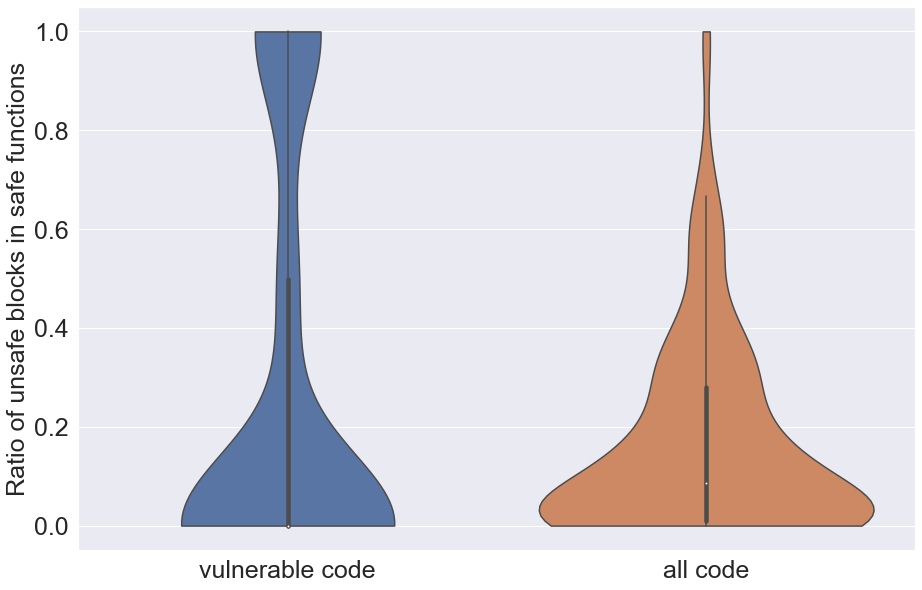

In [24]:
from scipy.stats import wilcoxon
import seaborn as sns
df = pd.read_sql("SELECT * FROM vul_safe_unsafe", con=db.conn)
df["unsafe_trait"] = float('nan')
df_manual = pd.read_sql("SELECT * FROM vul_safe_unsafe_manual2", con=db.conn)
df_vul = df.append(df_manual, ignore_index=True)

df = pd.read_sql("SELECT * FROM total_safe_unsafe", con=db.conn)
df_regex = pd.read_sql("SELECT * FROM total_safe_unsafe_regex", con=db.conn)
df_total = df.append(df_regex, ignore_index=True)

def get_unsafe_safe_perc(df, version):
    total_safe_func = df['safe_func'].astype(float).sum()
    total_unsafe_func = df['unsafe_func'].astype(float).sum()
    total_unsafe_block = df['unsafe_block'].astype(float).sum()
    df["unsafe_func_perc"] = df.apply(lambda x: float(x.unsafe_func)/(float(x.safe_func)+float(x.unsafe_func)) if (float(x.safe_func)+float(x.unsafe_func))!=0 else 0, axis=1)
    df["unsafe_block_perc"] = df.apply(lambda x: float(x.unsafe_block)/(float(x.safe_func)) if (float(x.safe_func))!=0 else 0 , axis=1)
    df["unsafe_block_perc"] = df["unsafe_block_perc"].apply(lambda x: 1 if x >=1 else x)
    df["type"] = version
    return df
df_vul = get_unsafe_safe_perc(df_vul, "vulnerable code")
df_total = get_unsafe_safe_perc(df_total, "all code")
df = df_vul.append(df_total, ignore_index=True)

sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.violinplot(x="type",y="unsafe_block_perc", data=df, cut=0)
ax.set(ylabel='Ratio of unsafe blocks in safe functions')
ax.set(xlabel='')
ax.tick_params(labelsize=25)
ax.yaxis.label.set_size(25)
ax.title.set_size(20)
fig = ax.get_figure()
fig.savefig('fig/rq2/block_distribution.png', facecolor='white', dpi=200) 

print("ratio of unsafe block in vulnerable code")
print(df_vul["unsafe_block_perc"].mean())
print(df_vul["unsafe_block_perc"].median())
print("ratio of unsafe function in vulnerable code")
print(df_vul["unsafe_func_perc"].mean())
print(df_vul["unsafe_func_perc"].median())

print("ratio of unsafe block in total code")
print(df_total["unsafe_block_perc"].mean())
print(df_total["unsafe_block_perc"].median())
print("ratio of unsafe function in total code")
print(df_total["unsafe_func_perc"].mean())
print(df_total["unsafe_func_perc"].median())

df_merge = (pd.merge(df_total, df_vul, on=['cve_id','hash']))
# print(df_merge)
res = wilcoxon(df_merge['unsafe_block_perc_x'], df_merge['unsafe_block_perc_y'])
print(res.statistic)
print(res.pvalue)
res = wilcoxon(df_merge['unsafe_func_perc_x'], df_merge['unsafe_func_perc_y'])
print(res.statistic)
print(res.pvalue)

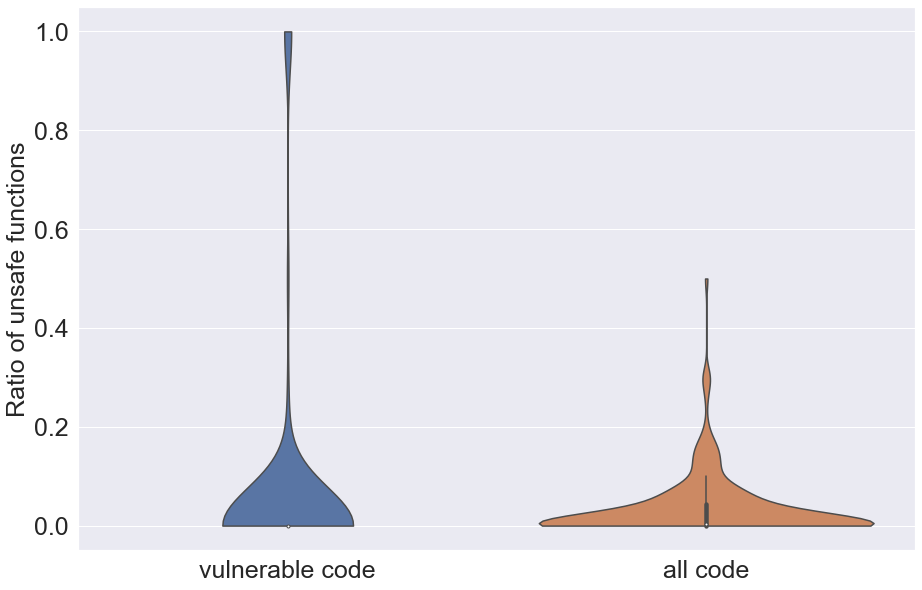

In [25]:
sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.violinplot(x="type",y="unsafe_func_perc", data=df, cut=0)
ax.set(ylabel='Ratio of unsafe functions')
ax.set(xlabel='')
ax.tick_params(labelsize=25)
ax.yaxis.label.set_size(25)
ax.title.set_size(20)
fig = ax.get_figure()
fig.savefig('fig/rq2/func_distribution.png', facecolor='white', dpi=200)